# Text classification with an RNN

Importing Required Modules

In [33]:
import zipfile

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Data Pre-Processing

Unzipping Fake and real news dataset

In [34]:
zip_file_path = './archive.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall()

Loading the datasets, then combining them into 1 dataframe.

In [35]:
# Load the first CSV file
df1 = pd.read_csv('Fake.csv')
df1['label'] = 0

# Load the second CSV file
df2 = pd.read_csv('True.csv')
df2['label'] = 1

# Merge the two DataFrames into a single one
df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

Removing unused attributes from the dataframe

In [36]:
df = df.drop('text', axis=1)
df = df.drop('subject', axis=1)
df = df.drop('date', axis=1)

print(df.shape)

(44898, 2)


Checking if the dataframe correctly was extracted and concated

In [37]:
df.head()

,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [38]:
df.tail()

,title,label
44893,'Fully committed' NATO backs new U.S. approach...,1
44894,LexisNexis withdrew two products from Chinese ...,1
44895,Minsk cultural hub becomes haven from authorities,1
44896,Vatican upbeat on possibility of Pope Francis ...,1
44897,Indonesia to buy $1.14 billion worth of Russia...,1


Counting how many occurences of each label there are.

The labels equal:
* true: 1
* fake: 0

In [39]:
print(df['label'].value_counts())

label
0    23481
1    21417
Name: count, dtype: int64


Split the data into training and testing subsets

In [40]:
texts_train, texts_test, labels_train, labels_test = train_test_split(df['title'].to_numpy(), df['label'].to_numpy(), test_size=0.2, random_state=42, shuffle=True)

Setting variable for data pre-preprocessing and text encoding

In [41]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

Cast the labels to a compatible data type

In [42]:
labels_train = labels_train.astype(np.int32)
labels_test = labels_test.astype(np.int32)

Creating the final training and testing dataset

In [43]:
# training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((texts_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((texts_test, labels_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Create the text encoder

Defining the encoder for training

In [44]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Defining the vocab for training

In [45]:
vocab = np.array(encoder.get_vocabulary())

# Training the Model

Defining the model architecture

In [46]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

Compiling the model

In [47]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 512)        788480    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        656384    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                 

Training the model

In [48]:
history = model.fit(train_dataset, 
                    steps_per_epoch=100, 
                    epochs=5, 
                    validation_data=test_dataset, 
                    validation_steps=100
                    )

Epoch 1/5
100/100 [==============================] - 139s 1s/step - loss: 0.2901 - accuracy: 0.8678 - val_loss: 0.1401 - val_accuracy: 0.9472
Epoch 2/5
100/100 [==============================] - 126s 1s/step - loss: 0.1548 - accuracy: 0.9423 - val_loss: 0.1590 - val_accuracy: 0.9323
Epoch 3/5
100/100 [==============================] - 131s 1s/step - loss: 0.1477 - accuracy: 0.9464 - val_loss: 0.1654 - val_accuracy: 0.9303
Epoch 4/5
100/100 [==============================] - 124s 1s/step - loss: 0.1430 - accuracy: 0.9484 - val_loss: 0.1206 - val_accuracy: 0.9566
Epoch 5/5
100/100 [==============================] - 125s 1s/step - loss: 0.1348 - accuracy: 0.9519 - val_loss: 0.1142 - val_accuracy: 0.9567


Saving the model for external use

In [49]:
tf.saved_model.save(model, 'my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


# Model Evaluation

Plotting the accuracy and loss of training and validation of the model

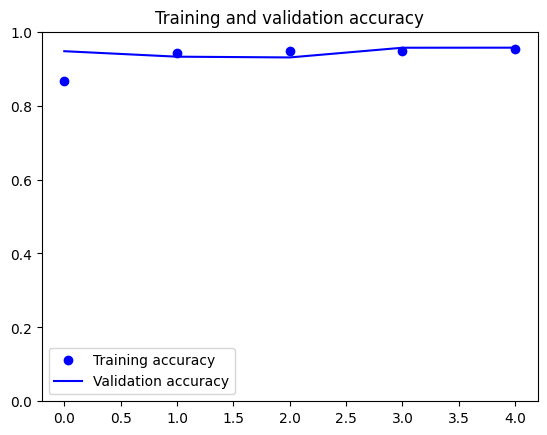

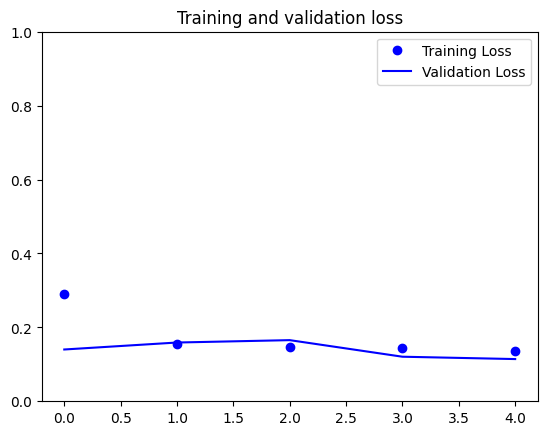

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim([0,1])
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.ylim([0,1])
plt.legend()
plt.show()

Calculating the accuracy and loss of the model on testing data

In [51]:
model_eval = model.evaluate(test_dataset)

141/141 [==============================] - 57s 406ms/step - loss: 0.1155 - accuracy: 0.9569


Predicting the labels of the testing data with the model

In [52]:
model_pred = model.predict(test_dataset)
model_pred = np.argmax(model_pred, axis=1)

141/141 [==============================] - 70s 457ms/step


Displaying the Confusion Matrix of the prediction

Text(0.5, 1.0, 'RNN Accuracy Score: 0.9569042325019836')

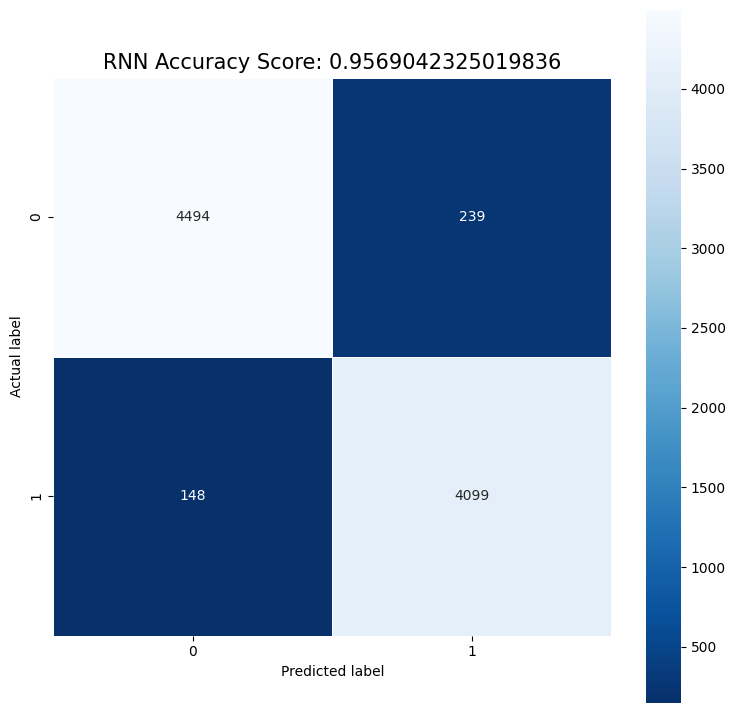

In [53]:
test_text_dataset = test_dataset.map(lambda x, y: x)
test_texts = np.concatenate([x.numpy() for x in test_text_dataset])

test_labels_dataset = test_dataset.map(lambda x, y: y)
test_labels = np.concatenate([y.numpy() for y in test_labels_dataset])

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(test_labels, model_pred), annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('RNN Accuracy Score: {0}'.format(model_eval[1]), size = 15)

Displaying the Classification Report

In [54]:
report = classification_report(test_labels, model_pred, output_dict=True)
report_df = pd.DataFrame.from_dict(report)
report_df.index.name = 'RNN Classification Report'
report_df.head(50).transpose()

RNN Classification Report,precision,recall,f1-score,support
0,0.968117,0.949503,0.958720,4733.000000
1,0.944905,0.965152,0.954921,4247.000000
accuracy,0.956904,0.956904,0.956904,0.956904
macro avg,0.956511,0.957328,0.956821,8980.000000
weighted avg,0.957139,0.956904,0.956923,8980.000000


# Model Testing

In [55]:
sample_text = ('NASA confirms aliens have been living among us for centuries.')

text_predict = model.predict(np.array([sample_text]))
text_predict = np.argmax(text_predict, axis=1)
print(text_predict)

1/1 [==============================] - 10s 10s/step
[0]


In [56]:
sample_text = ('Labor, Anthony Albanese make history with 2022 federal election victory')

text_predict = model.predict(np.array([sample_text]))
text_predict = np.argmax(text_predict, axis=1)
print(text_predict)

1/1 [==============================] - 0s 23ms/step
[1]
